# Fluxing with PYPIT [v2]

In [1]:
%matplotlib inline

In [2]:
# import
from importlib import reload
import os
from matplotlib import pyplot as plt
import glob
import numpy as np

from astropy.table import Table

from pypeit import fluxspec
from pypeit.spectrographs.util import load_spectrograph

# For the standard User (Running the script)

### Generate the sensitivity function from an extracted standard star

#### Here is an example fluxing file (see the fluxing docs for details):
    # User-defined fluxing parameters
    [rdx]
       spectrograph = vlt_fors2
    [fluxcalib]
       balm_mask_wid = 12.
       std_file = spec1d_STD_vlt_fors2_2018Dec04T004939.578.fits
       sensfunc = bpm16274_fors2.fits


#### Here is the call, and the sensitivity function is written to bpm16274_fors2.fits

    pypit_flux_spec fluxing_filename --plot

### Apply it to all spectra a spec1d science file

#### Add a flux block and you can comment out the std_file parameter to avoid remaking the sensitivity function

    # User-defined fluxing parameters
    [rdx]
       spectrograph = vlt_fors2
    [fluxcalib]
       balm_mask_wid = 12.
       #std_file = spec1d_STD_vlt_fors2_2018Dec04T004939.578.fits
       sensfunc = bpm16274_fors2.fits

    flux read
      spec1d_UnknownFRBHostY_vlt_fors2_2018Dec05T020241.687.fits FRB181112_fors2_1.fits
      spec1d_UnknownFRBHostY_vlt_fors2_2018Dec05T021815.356.fits FRB181112_fors2_2.fits
      spec1d_UnknownFRBHostY_vlt_fors2_2018Dec05T023349.816.fits FRB181112_fors2_3.fits
    flux end

#### The new files contain fluxed spectra (and the original, unfluxed data too)

    pypit_flux_spec fluxing_filename 

### Multi-detector (DEIMOS)
    pypit_flux_spec sensfunc --std_file=spec1d_G191B2B_DEIMOS_2017Sep14T152432.fits  --instr=keck_deimos --sensfunc_file=sens.yaml --multi_det=3,7

----

# For Developers (primarily)

## To play along from here, you need the Development suite *reduced* 

### And the $PYPIT_DEV environmental variable pointed at it

In [3]:
os.getenv('PYPEIT_DEV')

'/home/xavier/local/Python/PypeIt-development-suite/'

## Instrument and parameters

In [4]:
spectrograph = load_spectrograph('shane_kast_blue')
par = spectrograph.default_pypeit_par()

## Instantiate

In [5]:
FxSpec = fluxspec.FluxSpec(spectrograph, par['fluxcalib'])

[INFO]    :: flux.py 899 load_extinction_data() - Using mthamextinct.dat for extinction corrections.


## Sensitivity function

In [6]:
std_file = os.getenv('PYPEIT_DEV')+'Cooked/Science/spec1d_Feige66_KASTb_2015May20T041246.960.fits'
sci_file = os.getenv('PYPEIT_DEV')+'Cooked/Science/spec1d_J1217p3905_KASTb_2015May20T045733.560.fits'

### Load

In [7]:
FxSpec.load_objs(std_file, std=True)

[INFO]    :: fluxspec.py 118 load_objs() - Loaded 1 spectra from the spec1d standard star file: /home/xavier/local/Python/PypeIt-development-suite/Cooked/Science/spec1d_Feige66_KASTb_2015May20T041246.960.fits


## Find the standard (from the brightest spectrum)

In [8]:
_ = FxSpec.find_standard()

[INFO]    :: flux.py 980 find_standard() - Putative standard star <Table length=1>
 shape [2]   slit_spat_pos ...              idx              
   int64         object    ...             str30             
------------ ------------- ... ------------------------------
2048 .. 1024          None ... SPAT0169-SLIT0000-DET01-SCI023 has a median boxcar count of 16123.35030125018


## Sensitivity Function

In [9]:
sensfunc = FxSpec.generate_sensfunc()
sensfunc

[INFO]    :: flux.py 183 generate_sensfunc() - Applying extinction correction
[INFO]    :: flux.py 899 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: flux.py 194 generate_sensfunc() - Get standard model
[INFO]    :: flux.py 806 find_standard_file() - Using standard star FEIGE66
[INFO]    :: flux.py 935 load_standard_file() - Loading standard star file: /home/xavier/local/Python/PypeIt/pypeit/data/standards/calspec/feige66_002.fits.gz
[INFO]    :: flux.py 936 load_standard_file() - Fluxes are flambda, normalized to 1e-17
[INFO]    :: flux.py 256 generate_sensfunc() - Set nresln to 20.0
[WORK IN ]::
[PROGRESS]:: flux.py 262 generate_sensfunc() - Should pull resolution from arc line analysis
[WORK IN ]::
[PROGRESS]:: flux.py 263 generate_sensfunc() - At the moment the resolution is taken as the PixelScale
[WORK IN ]::
[PROGRESS]:: flux.py 264 generate_sensfunc() - This needs to be changed!
[INFO]    :: flux.py 275 generate_sensfunc() - Masking spe

{'airmass': 1.039999961853,
 'cal_file': '/data/standards/calspec/feige66_002.fits',
 'exptime': 30,
 'flux_true': array([108617.20646913, 108608.07011527, 108599.49643101, ...,
         22264.55020703,  22255.55495019,  22236.20434085]),
 'sensfunc': array([291.83566374, 291.27190356, 290.69985019, ...,  98.53266317,
         98.82316933,  99.12490019]),
 'std_dec': '+25:03:59.9',
 'std_file': 'b24.fits.gz',
 'std_name': 'FEIGE66',
 'std_ra': '12:37:23.52',
 'wave': <Quantity [3428.29433099, 3429.18637002, 3430.07856344, ..., 5513.83046847,
            5514.93519165, 5516.03996933] Angstrom>,
 'wave_max': <Quantity 5516.03996933 Angstrom>,
 'wave_min': <Quantity 3428.29433099 Angstrom>}

### Plot

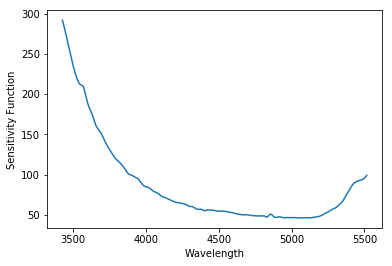

In [10]:
FxSpec.show_sensfunc()

In [11]:
FxSpec.steps

['find_standard', 'generate_sensfunc']

### Write

In [12]:
_ = FxSpec.save_sens_dict(FxSpec.sens_dict, outfile='sensfunc.fits')

[INFO]    :: fluxspec.py 417 save_sens_dict() - Wrote sensfunc to MasterFrame: sensfunc.fits


## Flux science

In [13]:
FxSpec.flux_science(sci_file)

[INFO]    :: fluxspec.py 125 load_objs() - Loaded 1 spectra from the spec1d science file: /home/xavier/local/Python/PypeIt-development-suite/Cooked/Science/spec1d_J1217p3905_KASTb_2015May20T045733.560.fits
[INFO]    :: flux.py 70 apply_sensfunc() - Fluxing boxcar extraction for:
             <Table length=1>
 shape [2]   slit_spat_pos ...              idx              
   int64         object    ...             str30             
------------ ------------- ... ------------------------------
2048 .. 1024          None ... SPAT0176-SLIT0000-DET01-SCI024
[WARNING] :: flux.py 79 apply_sensfunc() - Extinction correction applyed only if the spectra covers <10000Ang.
[INFO]    :: flux.py 82 apply_sensfunc() - Applying extinction correction
[INFO]    :: flux.py 899 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: flux.py 96 apply_sensfunc() -  Masking bad pixels
[INFO]    :: flux.py 70 apply_sensfunc() - Fluxing optimal extraction for:
             <Tabl

In [14]:
FxSpec.sci_specobjs

<Table length=1>
 shape [2]   slit_spat_pos ...              idx              
   int64         object    ...             str30             
------------ ------------- ... ------------------------------
2048 .. 1024          None ... SPAT0176-SLIT0000-DET01-SCI024

In [15]:
FxSpec.sci_specobjs[0].optimal

{'COUNTS': array([  9.27253079,  34.37363086,   9.92455604, ..., 195.55984732,
        170.83939294, 232.37931635]),
 'COUNTS_IVAR': array([0.00715238, 0.00610188, 0.0069734 , ..., 0.00214857, 0.0023191 ,
        0.00200826]),
 'FLAM': array([ 4.61585918, 17.06298991,  4.91263657, ..., 18.93336425,
        16.58861922, 22.63261267]),
 'FLAM_IVAR': array([0.02886302, 0.02476307, 0.02846016, ..., 0.22922052, 0.24596549,
        0.21171175]),
 'FLAM_SIG': array([5.88611969, 6.3547392 , 5.92763382, ..., 2.08868646, 2.01633603,
        2.17333924]),
 'MASK': array([ True,  True,  True, ...,  True,  True,  True]),
 'WAVE': <Quantity [3410.26943094, 3411.24899554, 3412.22841453, ..., 5513.9317573 ,
            5515.04321582, 5516.15476836] Angstrom>}

### Plot

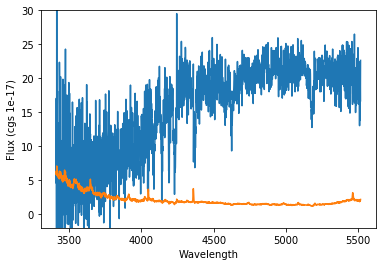

In [16]:
plt.clf()
ax = plt.gca()
ax.plot(FxSpec.sci_specobjs[0].optimal['WAVE'], FxSpec.sci_specobjs[0].optimal['FLAM'])
ax.plot(FxSpec.sci_specobjs[0].optimal['WAVE'], FxSpec.sci_specobjs[0].optimal['FLAM_SIG'])
ax.set_ylim(-2, 30.)
# 
ax.set_xlabel('Wavelength')
ax.set_ylabel('Flux (cgs 1e-17)')
plt.show()

### Write science frames

In [17]:
FxSpec.write_science('tmp.fits')

[INFO]    :: save.py 476 save_1d_spectra_fits() - Wrote 1D spectra to tmp.fits


In [18]:
FxSpec.steps

['find_standard',
 'generate_sensfunc',
 'save_sens_dict',
 'flux_science',
 'write_science']

## Instantiate and Load a sensitivity function

In [19]:
par['fluxcalib']['sensfunc'] = 'sensfunc.fits'

In [20]:
FxSpec2 = fluxspec.FluxSpec(spectrograph, par['fluxcalib'])

[INFO]    :: flux.py 899 load_extinction_data() - Using mthamextinct.dat for extinction corrections.
[INFO]    :: fluxspec.py 355 load_sens_dict() - Loading a pre-existing master calibration frame of type: sensfunc from filename: sensfunc.fits


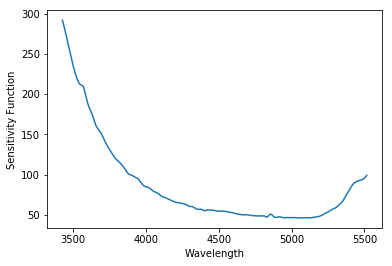

In [21]:
FxSpec2.show_sensfunc()

## Clean up


In [22]:
os.remove('sensfunc.fits')
os.remove('tmp.fits')

----

## Additional Development